# Explainable SVM for Medical Images


In [1]:
import os
import numpy as np
import cv2
import mlflow
import shap
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mlflow.models.signature import infer_signature


In [2]:
DATA_DIR = "/home/alidb/Desktop/Masters/ML4P/project/DATA/chest_xray/chest_xray"  

def load_data(img_size=128):
    images, labels = [], []
    for label, folder in enumerate(['NORMAL', 'PNEUMONIA']):
        path = os.path.join(DATA_DIR, 'train', folder)
        for file in os.listdir(path):
            print(os.path.join(path,file))
            if '.jpeg' in file:
                img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_size, img_size))
                images.append(img.flatten())
                labels.append(label)
    return np.array(images), np.array(labels)

def train_svm_model(X_train, y_train, kernel='linear'):
    model = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=True))
    model.fit(X_train, y_train)
    return model

def explain_with_lime(model, X, img_shape, index=0):
    explainer = lime.lime_image.LimeImageExplainer()

    def predict_fn(images):
        # Convert RGB images to grayscale, resize and flatten
        processed = []
        for img in images:
            if img.shape[-1] == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            else:
                gray = img
            resized = cv2.resize(gray, img_shape)
            processed.append(resized.flatten())
        return model.predict_proba(np.array(processed))

    # Use RGB image for visualization but convert to grayscale internally
    image = X[index].reshape(img_shape)
    image_rgb = np.stack([image]*3, axis=-1)  # Convert grayscale to 3-channel RGB

    explanation = explainer.explain_instance(image_rgb, predict_fn, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    plt.imshow(mark_boundaries(temp, mask))
    plt.title("LIME Explanation")
    plt.axis('off')
    plt.show()

def explain_with_shap(model, X_sample):
    explainer = shap.Explainer(model.predict_proba, X_sample[:100])
    shap_values = explainer(X_sample[:10])
    shap.image_plot(shap_values)

In [3]:
#Initialize DagsHub
import dagshub
dagshub.init(repo_owner= 'alihassandbouk', repo_name = 'ML4P', mlflow=True) 

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=8981c1bf-c5ef-42a8-a7d5-628a51803aa7&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=66fdee639e79abae88e85283c0fe0a00c243eb5f680bc9bccbd6fc335fe76eb9




Opening in existing browser session.


Accessing as alihassandbouk

Initialized MLflow to track repo "alihassandbouk/ML4P"

Repository alihassandbouk/ML4P initialized!

2025/04/04 20:21:56 INFO mlflow.tracking.fluent: Experiment with name 'Medical SVM Pneumonia Detection' does not exist. Creating a new experiment.


/home/alidb/Desktop/Masters/ML4P/project/DATA/chest_xray/chest_xray/train/NORMAL/IM-0499-0001-0002.jpeg
/home/alidb/Desktop/Masters/ML4P/project/DATA/chest_xray/chest_xray/train/NORMAL/IM-0584-0001.jpeg
/home/alidb/Desktop/Masters/ML4P/project/DATA/chest_xray/chest_xray/train/NORMAL/IM-0166-0001.jpeg
/home/alidb/Desktop/Masters/ML4P/project/DATA/chest_xray/chest_xray/train/NORMAL/IM-0429-0001.jpeg
/home/alidb/Desktop/Masters/ML4P/project/DATA/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1002-0001.jpeg
/home/alidb/Desktop/Masters/ML4P/project/DATA/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0846-0001.jpeg
/home/alidb/Desktop/Masters/ML4P/project/DATA/chest_xray/chest_xray/train/NORMAL/IM-0484-0001.jpeg
/home/alidb/Desktop/Masters/ML4P/project/DATA/chest_xray/chest_xray/train/NORMAL/IM-0629-0001-0001.jpeg
/home/alidb/Desktop/Masters/ML4P/project/DATA/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0599-0001.jpeg
/home/alidb/Desktop/Masters/ML4P/project/DATA/chest_xray/chest_xray/train/N

2025/04/04 20:30:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- SVM (linear) ---
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       295
           1       0.95      0.98      0.96       405

    accuracy                           0.96       700
   macro avg       0.96      0.95      0.96       700
weighted avg       0.96      0.96      0.96       700



  0%|          | 0/1000 [00:00<?, ?it/s]

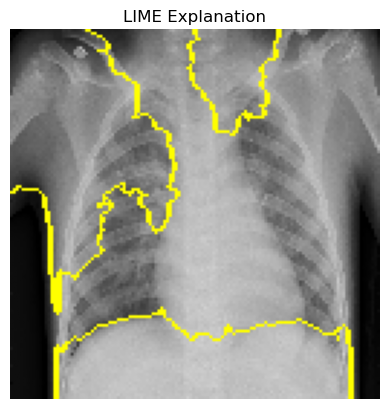

SHAP explanation failed: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 32769!
🏃 View run SVM_linear at: https://dagshub.com/alihassandbouk/ML4P.mlflow/#/experiments/0/runs/71bfbfbc67414e7f98bccdd84fe6d1e3
🧪 View experiment at: https://dagshub.com/alihassandbouk/ML4P.mlflow/#/experiments/0


In [4]:
mlflow.set_experiment("Medical SVM Pneumonia Detection")

X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for kernel in ['linear', ]:
    with mlflow.start_run(run_name=f"SVM_{kernel}"):
        model = train_svm_model(X_train, y_train, kernel)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        mlflow.log_param("kernel", kernel)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(model, f"svm_{kernel}_model")
        print(f"\n--- SVM ({kernel}) ---\n", classification_report(y_test, y_pred))

        explain_with_lime(model.named_steps['svc'], X_test, img_shape=(128, 128), index=0)
        
        try:
            explain_with_shap(model.named_steps['svc'], X_test)
        except Exception as e:
            print(f"SHAP explanation failed: {e}")

In [ ]:
import mlflow
with mlflow.start_run():
    mlflow.log_param("")